In [10]:
import argparse
import torch
from pathlib import Path
from torchvision.utils import make_grid
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from utils import read_json

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 10]

aevb_file = 'mnist_saved/models/MNIST/aevb/checkpoint-epoch30.pth'
aevb_config = 'mnist_saved/models/MNIST/aevb/config.json'
wiseub_file = 'mnist_saved/models/MNIST/wiseub/checkpoint-epoch30.pth'
wiseub_config = 'mnist_saved/models/MNIST/aevb/config.json'
seed = 0

aevb_config = read_json(Path(aevb_config))
wiseub_config = read_json(Path(wiseub_config))

aevb_model = getattr(module_arch, aevb_config['arch']['type'])()
wiseub_model = getattr(module_arch, wiseub_config['arch']['type'])()


checkpoint = torch.load(aevb_file)
state_dict = checkpoint['state_dict']
aevb_model.load_state_dict(state_dict)

checkpoint = torch.load(wiseub_file)
state_dict = checkpoint['state_dict']
wiseub_model.load_state_dict(state_dict)

# prepare model for testing
aevb_model = aevb_model.cuda()
aevb_model.eval()
wiseub_model = wiseub_model.cuda()
wiseub_model.eval()

MNIST_VAE(
  (enc): _small_encoder(
    (enc_convs): Sequential(
      (0): ConstantPad1d(padding=(2, 1), value=0.0)
      (1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (2): ReLU(inplace)
      (3): ConstantPad1d(padding=(2, 1), value=0.0)
      (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (5): ReLU(inplace)
      (6): ConstantPad1d(padding=(1, 1), value=0.0)
      (7): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (8): ReLU(inplace)
      (9): _Flatten()
    )
    (mu_linear): Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=2, bias=True)
    )
    (logvar_linear): Linear(in_features=192, out_features=2, bias=True)
  )
  (dec): _small_decoder(
    (dec_linears): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=16, out_features=128, bias=True)
      (3): ReLU(in

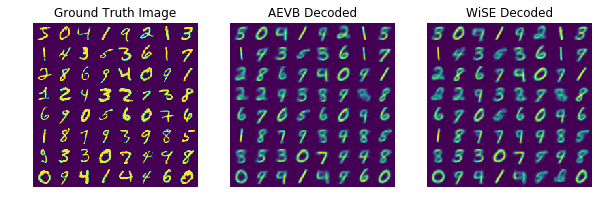

In [43]:

data_loader = module_data.MnistDataLoader(aevb_config['data_loader']['args']['data_dir'], 64, False)

with torch.no_grad():
    for data in data_loader:
        latent1, *_, out1 = aevb_model(data.cuda())
        latent2, *_, out2 = wiseub_model(data.cuda())
        break
gt_image = make_grid(data, nrow=8).permute(1, 2, 0).numpy().mean(2)
aevb_image = make_grid(out1.squeeze(1).sigmoid_().cpu(), nrow=8).permute(1, 2, 0).numpy().mean(2)
wiseub_image = make_grid(out2.squeeze(1).sigmoid_().cpu(), nrow=8).permute(1, 2, 0).numpy().mean(2)


plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Ground Truth Image")
plt.imshow(gt_image)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("AEVB Decoded")
plt.imshow(aevb_image)
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("WiSE Decoded")
plt.imshow(wiseub_image)
plt.show()


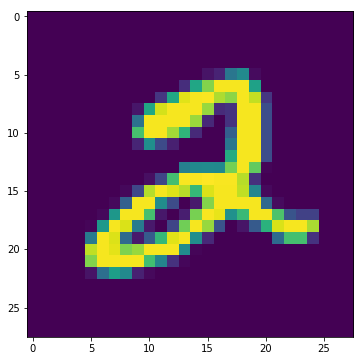

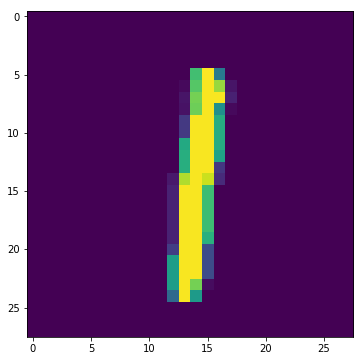

In [59]:
#data = data.numpy()
start_image = data[5]
end_image = data[40]

plt.rcParams['figure.figsize'] = [6] * 2
plt.imshow(start_image[0])
plt.show()
plt.imshow(end_image[0])
plt.show()


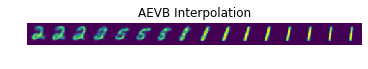

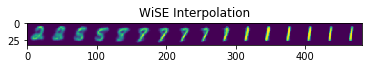

In [66]:
inter_size = 16
weight = torch.linspace(0, 1, inter_size)
weight = torch.stack((weight.flip(0), weight), 1).cuda()

input1 = weight @ torch.cat((latent1[5], latent1[40]))
input2 = weight @ torch.cat((latent2[5], latent2[40]))

with torch.no_grad():
    out1 = aevb_model(z=input1)
    out2 = wiseub_model(z=input2)

aevb_interp = make_grid(out1.sigmoid_().cpu(), nrow=inter_size).permute(1, 2, 0).numpy().mean(2)
wiseub_interp = make_grid(out2.sigmoid_().cpu(), nrow=inter_size).permute(1, 2, 0).numpy().mean(2)


#plt.subplot(2, 1, 1)
plt.axis('off')
plt.title("AEVB Interpolation")
plt.imshow(aevb_interp)
plt.show()
#plt.subplot(2, 1, 2)
plt.title("WiSE Interpolation")
plt.imshow(wiseub_interp)
plt.show()